# Moneyball ML

Major League Baseball (MLB) has made a shift toward data-driven decision-making in the past 20 years. Initially driven by more traditional statistics that could be compiled by a human scorekeeper, the trend in recent years has been to embrace machine-captured StatCast data to evaluate players. However, many of the statistics cited by baseball enthusiasts and commentators remain those which can be derived from the traditional statistics, and not their richer StatCast counterparts. For example weighted overall batting average aka wOBA, a common metric for hitting performance, is an amalgamation of at-bats, singles, doubles, walks, etc as indicated by the below definition:

wOBA flash 
      Graphic source: FanGraphs, wOBA definition, see https://library.fangraphs.com/offense/woba/

Furthermore, StatCast data is typically used to assess a player's potential, independent or in conjunction with conventional metrics. As extensive information on historical MLB seasons and its players have been compiled, it is possible to analyze StatCast data for its predictive value in the context of other important outcomes such as win rate and run differential. Notably its predictive value here can be compared against the now conventional statistics that rely on the non-Statcast-sourced data. I propose to analyze and model the relationship to predict game outcomes with inputs that are: 
- Strictly sourced from conventional, non-Statcast reporting methods
- Strictly sourced from Statcast
- A combination of A and B above

In so doing, I hope to shed light on the relative value of the newer, more expensive, and often-touted metric source. The data that underpins the proposed analysis is available on the MLB website, a partial list of relevant datasets is provided here: 
- Pitch tempo: https://baseballsavant.mlb.com/leaderboard/pitch-tempo
- Pitch movement: https://baseballsavant.mlb.com/leaderboard/pitch-movement
- Bat tracking : https://baseballsavant.mlb.com/leaderboard/bat-tracking
- Batted ball profile: https://baseballsavant.mlb.com/leaderboard/batted-ball

While the structured nature of these datasets supports classical machine learning (ML) methods, the volume and complexity also provide an interesting testbed for neural-network-based ML algorithms.

## To do: 
- what data do we want to train on? 
    - every table we're ingesting is quite large ... are we going to handle hundreds of columns per? how are we going to aggregate? 
    - what is the value we're trying to predict? do we have ground truth? 
        - statcast often doesn't have a temporal anchor aka timestamp beyond the season it's reported for... we can't use it to predict game outcomes, annoyingly... 
        - are we trying to predict team records win/losses, runs for and against, standing? win percent? 
        - what if we rolled up these, then rolled them up to the team they played for, then we try to predict the teams win rate? 
            - pitcher
            - hitter
            - fielder
            - runner
            - catcher
        - the model almost certainly needs to have data on the other teams -- a teams performance is only useful in the context of other performances... nobody knows what a C+ is unless you compare to the distribution of the league, division
- ensure the balance of conventional and statcast statistics are collected for 2024, check the below catalog against what we have through pybaseball and manual download before moving on
- remove any columns that have run information blended in or are composite metrics -- stuff like WAR is a post-hoc analysis and taints the data
    - go through hitter and pitcher stats to ensure this is dropped!
- complete the function that one-hot encodes, ordinal encodes, drops non-numeric columns, fills nans, etc... we can't do manual triage on hundreds of statcast features!
- figure out how to hold data out for predictions ... I don't want to go collect this all for prior year as well, perhaps we pick a number of teams that are the train set, others that are the validation set, and still others that are the test set and never cross paths with the algorithms until we assess performance. Though... I could just use the 'year' variable hear to allow re-running everything for another season. More work to manuall hunt down the datasets though... 
- decide what the role of time-series is here... the record/schedule provides, but many of the stats do not (summary statistics) -- maybe make dataframes for summary stats and for time series? maybe these support different models?
- train the non-neural classifier 
- figure HPO for above 
- train a neural classifier 
- figure HPO for above 

In [2]:
from pybaseball import *
cache.enable()

In [3]:
import re 
import argparse
from datetime import datetime
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn import metrics
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification

# Utilities

In [218]:
# Bring in our growing list of utilities and pipeline functions
import app

# Data

### Catalog

Here are all of the major statistics reported on MLB.com, minus those that blend post-hoc analysis (taints the predictors with run value, wins, etc), composite or less relevant data

- Top Performers : Composite, ignore
- Custom Leaderboards : Composite
- Park Factors : Relevant, but unclear how to incorporate - return to this
- Timer Infractions : Ignore

**Hitting**
- Bat Tracking
- Batted Ball Profile
- Exit Velocity & Barrels
- Expected Statistics
- Home Runs
- Percentile Rankings
- Pitch Arsenal Stats
- Pitch Tempo
- Rolling Windows

**Pitching**
- Active Spin
- Arm Angle
- Bat Tracking
- Exit Velocity & Barrels
- Expected Statistics
- Home Runs
- Percentile Rankings
- Pitch Arsenal Stats
- Pitch Arsenals
- Pitch Movement
- Pitch Tempo
- Running Game
- Spin Direction - Comparison
- Spin Direction - Pitches

**Fielding**
- Arm Strength
- Arm Value
- Catcher Blocking
- Catcher Framing
- Catcher Pop Time
- Catcher Throwing
- Outfield Catch Probability
- Outfield Directional OAA
- Outfielder Jump
- Outs Above Average

**Running**
- Baserunning Run Value
- Basestealing
- Extra Bases Taken
- Sprint Speed

**Positioning**
- Batting Stance
- Batter Positioning
- Fielder - All
- Fielder - Situational
- Pitcher Positioning
- Team Positioning

## Analysis Parameters

In [309]:
year = 2024

## Team Lookup

In [4]:
# No change in teams recently, source from the 2020 data
# Note the trigraph variance between the data sources... fg = FanGraphs, BR = Baseball REfernce, retro = Retrosheet, Lahman = lgID(?) 
teams = team_ids(2020)
teams

,yearID,lgID,teamID,franchID,teamIDfg,teamIDBR,teamIDretro
2875,2020,AL,BAL,BAL,2,BAL,BAL
2876,2020,AL,BOS,BOS,3,BOS,BOS
2877,2020,AL,CHA,CHW,4,CHW,CHA
2878,2020,AL,CLE,CLE,5,CLE,CLE
2879,2020,AL,DET,DET,6,DET,DET
2880,2020,AL,HOU,HOU,21,HOU,HOU
2881,2020,AL,KCA,KCR,7,KCR,KCA
2882,2020,AL,LAA,ANA,1,LAA,ANA
2883,2020,AL,MIN,MIN,8,MIN,MIN
2884,2020,AL,NYA,NYY,9,NYY,NYA


In [5]:
teams.teamID.unique()

array(['BAL', 'BOS', 'CHA', 'CLE', 'DET', 'HOU', 'KCA', 'LAA', 'MIN',
       'NYA', 'OAK', 'SEA', 'TBA', 'TEX', 'TOR', 'ARI', 'ATL', 'CHN',
       'CIN', 'COL', 'LAN', 'MIA', 'MIL', 'NYN', 'PHI', 'PIT', 'SDN',
       'SFN', 'SLN', 'WAS'], dtype=object)

## Player Lookup

In [6]:
register = chadwick_register(save=True)

In [7]:
players = register[(register.mlb_played_first <= 2024.0) & (register.mlb_played_last >= 2024.0)]

In [8]:
players.head()

,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
21,Miller,Owen,680911,millo002,milleow01,24655,2021.0,2024.0
24,Edman,Tommy,669242,edmat001,edmanto01,19470,2019.0,2025.0
30,Meeker,James,703231,meekj001,meekeja01,-1,2024.0,2024.0
31,Castillo,Diego,660636,castd004,castidi02,19906,2022.0,2024.0
73,Zastryzny,Rob,642239,zastr001,zastrro01,15094,2016.0,2024.0


In [9]:
jwood = players[(players.name_last == 'Wood') & (players.name_first == 'James')]
jwood

,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
15788,Wood,James,695578,woodj004,woodja03,-1,2024.0,2025.0


In [10]:
playerid_reverse_lookup([players.iloc[115].key_mlbam])

,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,lee,jung hoo,808982,lee-j001,leeju01,33824,2024.0,2025.0


## Spray Chart

In [11]:
data = statcast_batter('2024-01-01', '2024-12-01', 695578)

/Users/jason/Local/school/520/moneyball-ml/venv/lib/python3.13/site-packages/pybaseball/plotting.py:138: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sub_data = sub_data[sub_data['events'].notna()][sub_data['hc_x'].notna()][sub_data['hc_y'].notna()]
/Users/jason/Local/school/520/moneyball-ml/venv/lib/python3.13/site-packages/pybaseball/plotting.py:138: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sub_data = sub_data[sub_data['events'].notna()][sub_data['hc_x'].notna()][sub_data['hc_y'].notna()]


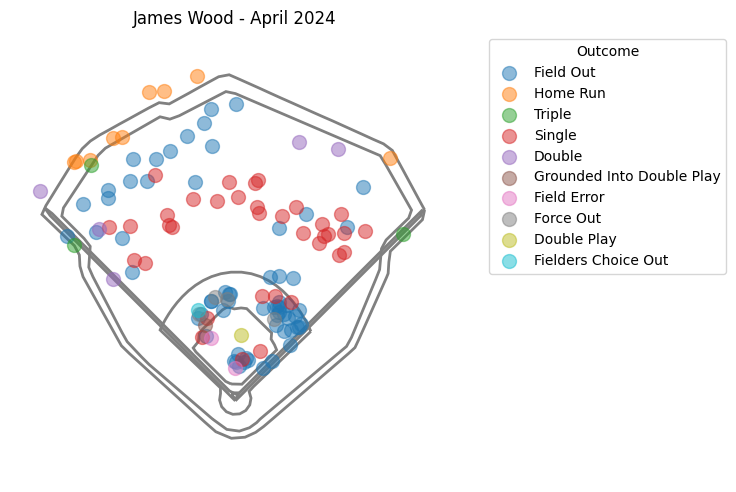

<Axes: title={'center': 'James Wood - April 2024'}>

In [12]:
spraychart(data[data['home_team'] == 'WSH'], 'nationals', title='James Wood - April 2024')

## Strike Zone

In [13]:
players[players.name_last == 'Gore']

,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
16740,Gore,MacKenzie,669022,gorem001,gorema01,22201,2022.0,2025.0


In [14]:
early = statcast_pitcher('2024-04-01', '2024-04-30', 669022)
late = statcast_pitcher('2024-08-01', '2024-08-31', 669022)

In [15]:
data.pitch_type.unique()

array(['KC', 'FF', 'CH', 'CU', 'SL', 'SI', 'FS', 'FC', 'ST', 'SV', 'CS',
       'KN', None], dtype=object)

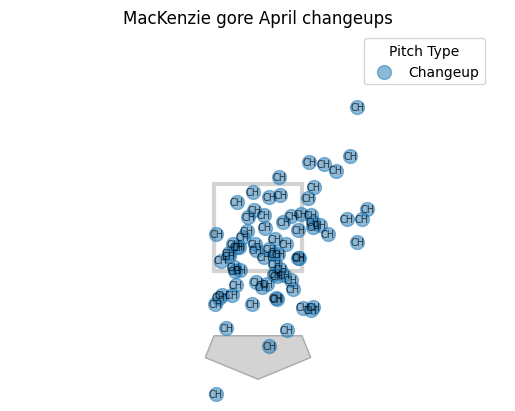

<Axes: title={'center': 'MacKenzie gore April changeups'}>

In [16]:
plot_strike_zone(early[early.pitch_type == 'CH'], title = "MacKenzie gore April changeups")

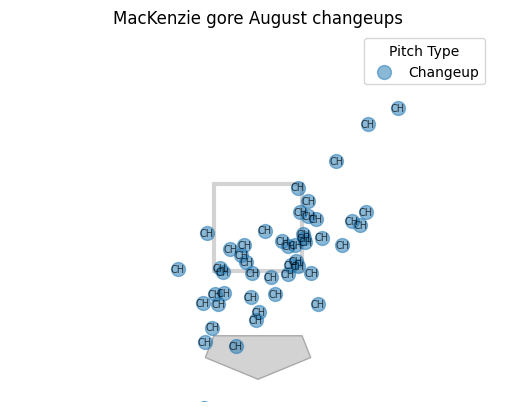

<Axes: title={'center': 'MacKenzie gore August changeups'}>

In [17]:
plot_strike_zone(late[late.pitch_type == 'CH'], title = "MacKenzie gore August changeups")

## Schedule and Results

In [18]:
# This is a baseball reference lookup, use the correct trigraph... 
teams.teamIDBR.unique()

array(['BAL', 'BOS', 'CHW', 'CLE', 'DET', 'HOU', 'KCR', 'LAA', 'MIN',
       'NYY', 'OAK', 'SEA', 'TBR', 'TEX', 'TOR', 'ARI', 'ATL', 'CHC',
       'CIN', 'COL', 'LAD', 'MIA', 'MIL', 'NYM', 'PHI', 'PIT', 'SDP',
       'SFG', 'STL', 'WSN'], dtype=object)

Interesting to note Washington shows as WSN, WAS and WSH - may need to do some wildcarding depending on the data source

In [19]:
results = pd.DataFrame()
for team in teams.teamIDBR.unique(): 
    print(f"Retrieving results for {team}...")
    team_results = schedule_and_record(2024, team)
    results = pd.concat([results, team_results])

Retrieving results for BAL...
Retrieving results for BOS...
Retrieving results for CHW...
Retrieving results for CLE...
Retrieving results for DET...
Retrieving results for HOU...
Retrieving results for KCR...
Retrieving results for LAA...
Retrieving results for MIN...
Retrieving results for NYY...
Retrieving results for OAK...
Retrieving results for SEA...
Retrieving results for TBR...
Retrieving results for TEX...
Retrieving results for TOR...
Retrieving results for ARI...
Retrieving results for ATL...
Retrieving results for CHC...
Retrieving results for CIN...
Retrieving results for COL...
Retrieving results for LAD...
Retrieving results for MIA...
Retrieving results for MIL...
Retrieving results for NYM...
Retrieving results for PHI...
Retrieving results for PIT...
Retrieving results for SDP...
Retrieving results for SFG...
Retrieving results for STL...
Retrieving results for WSN...


In [20]:
results.shape

(4858, 20)

Just 2 games short of the theoretical 162 scheduled games * 30 teams... checks out!

In [21]:
results.head()

,Date,Tm,Home_Away,Opp,W/L,R,RA,Inn,W-L,Rank,GB,Win,Loss,Save,Time,D/N,Attendance,cLI,Streak,Orig. Scheduled
1,"Thursday, Mar 28",BAL,Home,LAA,W,11.0,3.0,9.0,1-0,1.0,Tied,Burnes,Sandoval,None,2:43,D,45029.0,.95,1.0,None
2,"Saturday, Mar 30",BAL,Home,LAA,W,13.0,4.0,9.0,2-0,2.0,0.5,Rodriguez,Canning,None,2:55,D,28420.0,.98,2.0,None
3,"Sunday, Mar 31",BAL,Home,LAA,L,1.0,4.0,9.0,2-1,2.0,1.5,Detmers,Wells,Estévez,2:19,D,20576.0,1.01,-1.0,None
4,"Monday, Apr 1",BAL,Home,KCR,W-wo,6.0,4.0,9.0,3-1,2.0,1.5,Kimbrel,Anderson,None,2:35,N,12666.0,.94,1.0,None
5,"Tuesday, Apr 2",BAL,Home,KCR,L,1.0,4.0,9.0,3-2,3.0,1.5,Marsh,Irvin,Smith,2:17,N,9404.0,1.00,-1.0,None


# Metrics

## Statcast Metrics

See documentation here: https://github.com/jldbc/pybaseball/blob/master/docs/statcast.md

### Pitching

In [26]:
# Pitch-level data only!
sc_all_april = statcast(start_dt="2024-4-1", end_dt="2024-4-30")
sc_all_april

This is a large query, it may take a moment to complete


100%|██████████| 30/30 [00:00<00:00, 106.06it/s]


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,pitcher_days_since_prev_game,batter_days_since_prev_game,pitcher_days_until_next_game,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle
2825,CH,2024-04-30,81.2,-2.75,5.42,"Crismatt, Nabil",572233,622503,home_run,hit_into_play,...,1,4,2,1,12,1,3.26,0.77,0.77,30.6
2898,CH,2024-04-30,81.4,-2.73,5.47,"Crismatt, Nabil",572233,622503,None,ball,...,1,4,2,1,12,1,2.94,0.43,0.43,30.0
3061,CH,2024-04-30,82.0,-2.63,5.6,"Crismatt, Nabil",572233,622503,None,called_strike,...,1,4,2,1,12,1,3.04,0.68,0.68,34.1
2405,SL,2024-04-30,87.8,-1.57,6.03,"McGough, Scott",606192,543518,field_out,hit_into_play,...,1,4,1,1,3,1,2.62,-0.36,-0.36,46.3
2435,FF,2024-04-30,93.6,-1.49,6.03,"McGough, Scott",606192,543518,None,ball,...,1,4,1,1,3,1,1.0,0.66,0.66,45.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3672,FF,2024-04-01,97.5,1.77,5.84,"Gore, MacKenzie",656582,669022,None,ball,...,1,0,<NA>,1,6,3,0.95,0.57,-0.57,44.6
3746,FF,2024-04-01,98.6,2.02,5.88,"Gore, MacKenzie",656582,669022,None,ball,...,1,0,<NA>,1,6,3,0.91,0.7,-0.7,40.7
3898,FF,2024-04-01,97.7,2.05,5.83,"Gore, MacKenzie",656582,669022,None,foul,...,1,0,<NA>,1,6,3,0.72,0.36,-0.36,40.4
4016,FF,2024-04-01,96.8,2.1,5.84,"Gore, MacKenzie",656582,669022,None,ball,...,1,0,<NA>,1,6,3,0.91,0.55,-0.55,39.8


In [219]:
sc = sc_all_april

In [224]:
sc.hit_distance_sc.fillna(0)

2825    426
2898      0
3061      0
2405     87
2435      0
       ... 
3672      0
3746      0
3898    147
4016      0
4064      0
Name: hit_distance_sc, Length: 116374, dtype: Int64

In [ ]:
drop_columns = ['player_name', 'spin_dir', 'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 'tfs_deprecated', 'tfs_zulu_deprecated']
onehot_columns = ['pitch_type', 'events', 'description']
ordinal_columns = []
dfc = canonicalize_data(sc_all_april, drop=drop_columns, onehot=onehot_columns, ordinal=ordinal_columns)

In [206]:
dfc.head()

,game_date,release_speed,release_pos_x,release_pos_z,batter,pitcher
2825,1714435200000000000,81.199997,-2.75,5.42,572233,622503
2898,1714435200000000000,81.400002,-2.73,5.47,572233,622503
3061,1714435200000000000,82.000000,-2.63,5.60,572233,622503
2405,1714435200000000000,87.800003,-1.57,6.03,606192,543518
2435,1714435200000000000,93.599998,-1.49,6.03,606192,543518


In [199]:
sc_all_april.spin_dir.unique()

<IntegerArray>
[<NA>]
Length: 1, dtype: Int64

In [332]:
# Is this a subset of above? Would presume, but investigate. 
sc_pitcher = statcast_pitcher('2024-04-01', '2024-07-15', player_id = 669022)
sc_pitcher

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,pitcher_days_since_prev_game,batter_days_since_prev_game,pitcher_days_until_next_game,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle
0,FF,2024-07-11,96.6,2.14,5.76,"Gore, MacKenzie",607043,669022,double,hit_into_play,...,3,2,5.0,1.0,9,1,0.90,0.45,0.45,47.7
1,FC,2024-07-11,91.9,2.02,5.81,"Gore, MacKenzie",607043,669022,None,blocked_ball,...,3,2,5.0,1.0,9,1,1.79,0.29,0.29,49.6
2,FF,2024-07-11,96.5,1.97,5.75,"Gore, MacKenzie",596019,669022,walk,ball,...,3,2,5.0,1.0,9,1,0.92,0.60,-0.60,48.1
3,FF,2024-07-11,96.3,1.92,5.71,"Gore, MacKenzie",596019,669022,None,swinging_strike,...,3,2,5.0,1.0,9,1,1.11,0.56,-0.56,46.5
4,CH,2024-07-11,87.2,2.11,5.62,"Gore, MacKenzie",596019,669022,None,blocked_ball,...,3,2,5.0,1.0,9,1,2.41,0.97,-0.97,46.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1818,FF,2024-04-01,97.5,1.77,5.84,"Gore, MacKenzie",656582,669022,None,ball,...,1,0,NaN,1.0,6,3,0.95,0.57,-0.57,44.6
1819,FF,2024-04-01,98.6,2.02,5.88,"Gore, MacKenzie",656582,669022,None,ball,...,1,0,NaN,1.0,6,3,0.91,0.70,-0.70,40.7
1820,FF,2024-04-01,97.7,2.05,5.83,"Gore, MacKenzie",656582,669022,None,foul,...,1,0,NaN,1.0,6,3,0.72,0.36,-0.36,40.4
1821,FF,2024-04-01,96.8,2.10,5.84,"Gore, MacKenzie",656582,669022,None,ball,...,1,0,NaN,1.0,6,3,0.91,0.55,-0.55,39.8


In [333]:
sc_pitcher_ev = statcast_pitcher_exitvelo_barrels(year, minBBE=1)
sc_pitcher_ev

,"last_name, first_name",player_id,attempts,avg_hit_angle,anglesweetspotpercent,max_hit_speed,avg_hit_speed,ev50,fbld,gb,max_distance,avg_distance,avg_hr_distance,ev95plus,ev95percent,barrels,brl_percent,brl_pa
0,"Webb, Logan",657277,617,2.5,32.1,120.4,89.8,77.9,95.2,86.8,464,133,426.0,285,46.2,43,7.0,5.1
1,"Lugo, Seth",607625,598,10.7,32.8,115.1,88.5,77.3,93.1,84.5,445,163,407.0,233,39.0,48,8.0,5.7
2,"Nola, Aaron",605400,570,12.0,35.4,120.5,88.5,77.3,93.8,84.0,441,162,394.0,218,38.2,41,7.2,5.0
3,"Kirby, George",669923,568,14.8,30.5,113.9,89.0,78.8,91.9,88.1,433,164,402.0,206,36.3,46,8.1,5.9
4,"Corbin, Patrick",571578,568,10.0,37.3,116.3,90.8,79.9,93.8,88.9,440,161,406.0,265,46.7,47,8.3,6.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
849,"Suero, Wander",593833,1,18.2,100.0,109.0,109.0,109.0,109.0,NaN,353,353,NaN,1,100.0,1,100.0,100.0
850,"Cabrera, Oswaldo",665828,1,-8.6,0.0,87.9,87.9,87.9,NaN,87.9,13,13,NaN,0,0.0,0,0.0,0.0
851,"Torrens, Luis",620443,1,-7.6,0.0,97.0,97.0,97.0,NaN,97.0,21,21,NaN,1,100.0,0,0.0,0.0
852,"Sanó, Miguel",593934,1,-24.9,0.0,83.3,83.3,83.3,NaN,83.3,6,6,NaN,0,0.0,0,0.0,0.0


In [334]:
sc_pitcher_expected = statcast_pitcher_expected_stats(year)
sc_pitcher_expected

,"last_name, first_name",player_id,year,pa,bip,ba,est_ba,est_ba_minus_ba_diff,slg,est_slg,est_slg_minus_slg_diff,woba,est_woba,est_woba_minus_woba_diff,era,xera,era_minus_xera_diff
0,"Webb, Logan",657277,2024,841,617,0.258,0.272,-0.014,0.355,0.412,-0.057,0.288,0.320,-0.032,3.47,4.31,-0.836
1,"Lugo, Seth",607625,2024,836,598,0.229,0.243,-0.014,0.353,0.389,-0.036,0.278,0.300,-0.022,3.00,3.75,-0.745
2,"Nola, Aaron",605400,2024,820,570,0.247,0.244,0.003,0.421,0.388,0.033,0.310,0.299,0.011,3.57,3.72,-0.153
3,"Gilbert, Logan",669302,2024,803,542,0.196,0.224,-0.028,0.353,0.369,-0.016,0.255,0.276,-0.021,3.23,3.14,0.095
4,"Wheeler, Zack",554430,2024,787,503,0.192,0.197,-0.005,0.328,0.328,0.000,0.256,0.261,-0.005,2.56,2.80,-0.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,"Banda, Anthony",607455,2024,209,139,0.238,0.227,0.011,0.351,0.358,-0.007,0.281,0.281,0.000,3.08,3.26,-0.179
362,"Mlodzinski, Carmen",669387,2024,209,142,0.223,0.227,-0.004,0.315,0.336,-0.021,0.272,0.284,-0.012,3.38,3.34,0.035
363,"Ramírez, Yohan",670990,2024,208,134,0.280,0.252,0.028,0.423,0.386,0.037,0.351,0.328,0.023,6.20,4.56,1.640
364,"Ferguson, Tyler",621053,2024,207,119,0.178,0.211,-0.033,0.306,0.361,-0.055,0.262,0.297,-0.035,3.68,3.67,0.012


In [ ]:
# Aggregate 
sc_pitch_spin = pd.read_csv("data/active_spin_2024.csv")
sc_pitch_spin

,"last_name, first_name",pitch_hand,active_spin_fourseam,active_spin_sinker,active_spin_cutter,active_spin_changeup,active_spin_splitter,active_spin_curve,active_spin_slider,active_spin_sweeper,active_spin_slurve
0,"Roberts, Ethan",R,NaN,60.2,45.6,NaN,NaN,NaN,NaN,69.5,NaN
1,"Uribe, Abner",R,NaN,69.9,NaN,NaN,NaN,NaN,34.7,NaN,NaN
2,"Ashby, Aaron",L,NaN,83.9,NaN,77.0,NaN,88.1,45.9,NaN,NaN
3,"Bowman, Matt",R,NaN,89.6,60.3,NaN,81.9,NaN,NaN,49.5,NaN
4,"Peguero, Elvis",R,NaN,94.3,NaN,NaN,NaN,NaN,25.6,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
703,"Cimber, Adam",R,57.3,63.7,NaN,NaN,NaN,NaN,68.2,NaN,NaN
704,"Adams, Austin",R,55.9,54.1,NaN,NaN,NaN,NaN,33.6,NaN,NaN
705,"Cosgrove, Tom",L,55.1,59.1,NaN,NaN,NaN,NaN,NaN,60.6,NaN
706,"Turnbull, Spencer",R,53.3,71.7,NaN,90.0,NaN,87.6,40.9,48.6,NaN


In [ ]:
# Pitch movement is not a valid symbol in the package despite the docs - pull from baseballsavant.mlb.com manually
sc_pitch_movement = pd.read_csv("data/pitch_movement_2024.csv")
sc_pitch_movement

,year,"last_name, first_name",pitcher_id,team_name,team_name_abbrev,pitch_hand,avg_speed,pitches_thrown,total_pitches,pitches_per_game,...,league_break_z,diff_z,rise,pitcher_break_z_induced,pitcher_break_x,league_break_x,diff_x,tail,percent_rank_diff_z,percent_rank_diff_x
0,2024,"Gore, MacKenzie",669022,Nationals,WSH,L,96.0,1657,2994,18.481481,...,-13.7,1.6,11.0,17.6,5.9,-7.3,-1.4,-19.0,0.863309,0.285372
1,2024,"Peralta, Freddy",642547,Brewers,MIL,R,94.3,1650,3066,18.925926,...,-15.7,1.4,9.0,16.7,6.8,-8.4,-1.6,-19.0,0.829736,0.249400
2,2024,"Rodón, Carlos",607074,Yankees,NYY,L,95.4,1530,3102,19.148148,...,-13.6,1.3,9.0,17.8,8.8,-7.1,1.7,24.0,0.810552,0.695444
3,2024,"Gausman, Kevin",592332,Blue Jays,TOR,R,94.0,1487,2958,18.259259,...,-15.2,1.0,7.0,17.0,10.7,-7.4,3.3,44.0,0.738609,0.880096
4,2024,"Greene, Hunter",668881,Reds,CIN,R,97.6,1415,2563,15.820988,...,-12.8,0.5,4.0,16.6,8.9,-7.6,1.2,16.0,0.647482,0.635492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2384,2024,"Robertson, Nick",687798,Blue Jays,TOR,R,87.8,50,217,1.339506,...,-30.5,1.3,4.0,3.8,15.7,-14.4,1.3,9.0,NaN,NaN
2385,2024,"Wilson, Steven",621051,White Sox,CWS,R,81.7,50,623,3.845679,...,-36.0,-3.8,-11.0,8.7,15.9,-14.3,1.5,11.0,0.122605,0.747126
2386,2024,"Robert, Daniel",642016,Rangers,TEX,R,83.2,50,103,0.635802,...,-39.4,-3.2,-8.0,3.6,15.7,13.6,2.1,15.0,NaN,NaN
2387,2024,"Espino, Paolo",502179,Blue Jays,TOR,R,70.6,50,158,0.975309,...,-67.7,5.8,8.0,-17.0,15.0,13.6,1.4,11.0,NaN,NaN


### Batting

In [289]:
# Batting data!
sc_james_wood = statcast_batter("2024-1-1", "2024-12-31", 695578)

### Fielding 

See docs here: https://github.com/jldbc/pybaseball/blob/master/docs/statcast_fielding.md

In [ ]:
# Aggregate outs above average for the year
sc_fielding_oaa = statcast_outfield_directional_oaa(year, min_opp=1)
sc_fielding_oaa

,"last_name, first_name",player_id,attempts,n_outs_above_average,n_oaa_slice_back_left,n_oaa_slice_back,n_oaa_slice_back_right,n_oaa_slice_back_all,n_oaa_slice_in_left,n_oaa_slice_in,n_oaa_slice_in_right,n_oaa_slice_in_all
0,"Young, Jacob",696285,409,19,1,-2,2,2,5,5,7,18
1,"Varsho, Daulton",662139,348,16,3,4,4,11,2,2,1,5
2,"Siri, Jose",642350,355,16,2,0,2,4,3,4,5,12
3,"Siani, Michael",672279,255,16,3,1,4,8,2,2,5,8
4,"Doyle, Brenton",686668,448,15,3,5,3,11,0,1,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...
297,"Hernández, Teoscar",606192,337,-9,-2,0,-3,-5,1,-2,-2,-4
298,"Burleson, Alec",676475,147,-9,-3,0,-1,-5,-1,-2,-2,-5
299,"Winker, Jesse",608385,163,-11,-2,-2,-3,-7,-1,-2,-1,-4
300,"García, Adolis",666969,297,-12,-4,-3,-1,-8,-2,1,-2,-3


In [293]:
# Outfield catch probability is an aggregate statistic, these represent the totality of performance for the individual in the year queried
sc_catch_prob = statcast_outfield_catch_prob(year, min_opp=1)
sc_catch_prob

,"last_name, first_name",player_id,oaa,n_fieldout_5stars,n_opp_5stars,n_5star_percent,n_fieldout_4stars,n_opp_4stars,n_4star_percent,n_fieldout_3stars,n_opp_3stars,n_3star_percent,n_fieldout_2stars,n_opp_2stars,n_2star_percent,n_fieldout_1stars,n_opp_1stars,n_1star_percent
0,"Young, Jacob",696285,19,6,17,35.3,13,18,72.2,15,16,93.8,23,26,88.5,26,26,100.0
1,"Varsho, Daulton",662139,16,3,21,14.3,6,11,54.5,18,22,81.8,22,23,95.7,36,36,100.0
2,"Siri, Jose",642350,16,4,9,44.4,9,16,56.3,22,26,84.6,19,20,95.0,22,24,91.7
3,"Siani, Michael",672279,16,4,16,25.0,5,5,100.0,16,18,88.9,18,18,100.0,22,22,100.0
4,"Doyle, Brenton",686668,15,0,19,0.0,7,14,50.0,24,27,88.9,30,32,93.8,40,40,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,"Hernández, Teoscar",606192,-9,0,24,0.0,1,12,8.3,4,9,44.4,24,29,82.8,28,30,93.3
298,"Burleson, Alec",676475,-9,0,6,0.0,0,7,0.0,0,6,0.0,4,5,80.0,11,13,84.6
299,"Winker, Jesse",608385,-11,0,9,0.0,1,12,8.3,5,9,55.6,6,12,50.0,17,20,85.0
300,"García, Adolis",666969,-12,0,16,0.0,1,10,10.0,5,16,31.3,11,14,78.6,22,25,88.0


In [300]:
# Catch pop time - throws from release to arrival at targeted base
sc_pop_time = statcast_catcher_poptime(year, min_2b_att=1, min_3b_att=1)
sc_pop_time

,catcher,player_id,team_id,age,maxeff_arm_2b_3b_sba,exchange_2b_3b_sba,pop_2b_sba_count,pop_2b_sba,pop_2b_cs,pop_2b_sb,pop_3b_sba_count,pop_3b_sba,pop_3b_cs,pop_3b_sb
0,"Bailey, Patrick",NaN,137,25,84.6,0.60,58,1.85,1.83,1.86,2,1.40,1.42,1.37
1,"Realmuto, J.T.",NaN,143,33,85.1,0.65,39,1.85,1.85,1.84,4,1.42,1.41,1.45
2,"Lee, Korey",NaN,145,25,88.3,0.64,46,1.85,1.85,1.85,2,1.49,1.56,1.42
3,"Fermin, Freddy",NaN,118,29,84.3,0.64,23,1.88,1.85,1.92,2,1.54,NaN,1.54
4,"Jackson, Alex",NaN,139,28,85.0,0.66,26,1.96,1.86,1.99,2,1.39,NaN,1.39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,"Amaya, Miguel",NaN,112,25,80.5,0.70,50,2.04,2.08,2.03,2,1.57,1.64,1.49
69,"Barnes, Austin",NaN,119,34,75.9,0.58,27,2.00,2.09,1.99,2,1.49,1.46,1.52
70,"Del Castillo, Adrian",NaN,109,24,76.9,0.69,13,2.04,2.18,2.02,1,1.60,NaN,1.60
71,"Reetz, Jakson",NaN,137,28,80.3,0.77,3,2.11,NaN,2.11,1,1.53,NaN,1.53


In [301]:
# Catcher framing
sc_framing = statcast_catcher_framing(year, min_called_p=1)
sc_framing

,last_name,first_name,player_id,year,n_called_pitches,runs_extra_strikes,strike_rate,strike_rate_11,strike_rate_12,strike_rate_13,strike_rate_14,strike_rate_16,strike_rate_17,strike_rate_18,strike_rate_19
0,League Average,None,NaN,2024,144792,0,46.4,18.9,48.1,23.1,58.8,65.7,29.2,49.2,23.4
1,Bailey,Patrick,672275.0,2024,3214,16,52.5,23.3,57.4,28.4,64.6,70.5,29.8,54.8,32.2
2,Raleigh,Cal,663728.0,2024,3404,13,49.1,22.4,55.0,30.0,60.9,68.5,30.0,46.3,28.4
3,Wells,Austin,669224.0,2024,3111,12,48.6,23.0,49.3,23.9,58.1,66.0,31.5,55.1,29.3
4,Kirk,Alejandro,672386.0,2024,2586,10,49.8,21.7,50.7,21.9,67.3,61.2,34.6,56.1,28.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,Diaz,Yainer,673237.0,2024,3083,-7,45.2,19.4,54.4,26.6,61.6,62.7,23.0,40.8,22.4
97,Lee,Korey,686676.0,2024,2990,-7,43.0,18.9,45.5,13.7,60.2,60.6,23.2,48.6,19.3
98,Jeffers,Ryan,680777.0,2024,2280,-7,44.6,19.2,50.5,19.2,55.7,59.5,31.0,52.0,15.6
99,Campusano,Luis,669134.0,2024,2130,-8,44.0,17.7,49.7,20.7,46.7,69.1,25.2,48.0,24.4


In [302]:
# Fielding run value is an aggregate score -- should we employ or does it just pollute the raw predictors? 

### Running

In [325]:
sc_sprint = statcast_sprint_speed(year, min_opp=1)

In [327]:
sc_sprint.shape

(606, 10)

In [328]:
# Aggregate metric, not applicable to any time series
sc_sprint.head()

,"last_name, first_name",player_id,team_id,team,position,age,competitive_runs,bolts,hp_to_1b,sprint_speed
0,"Witt Jr., Bobby",677951,118,KC,SS,24,298,156.0,4.10,30.5
1,"Rojas, Johan",679032,143,PHI,CF,23,176,78.0,4.24,30.1
2,"De La Cruz, Elly",682829,113,CIN,SS,22,249,81.0,4.21,30.0
3,"Fitzgerald, Tyler",666149,137,SF,SS,26,99,47.0,4.30,30.0
4,"Clase, Jonatan",682729,141,TOR,LF,22,20,8.0,NaN,30.0


## Conventional Metrics

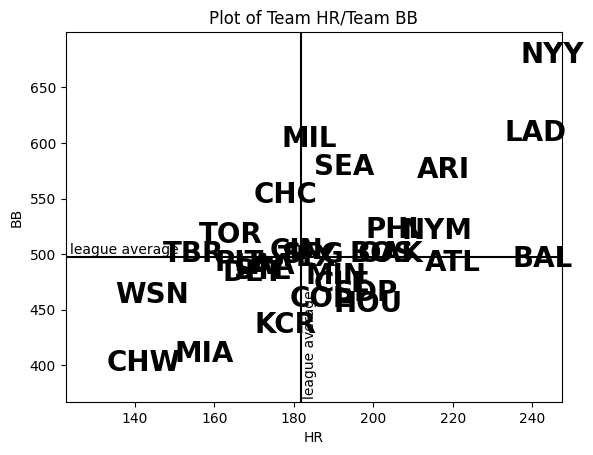

In [55]:
# https://github.com/jldbc/pybaseball/blob/master/docs/plotting.md
data = team_batting(2024)
plot_teams(data, "HR", "BB")

In [80]:
# API documentation at https://github.com/jldbc/pybaseball/blob/master/docs/batting_stats.md
batting = batting_stats(year, qual=1)

In [57]:
batting.shape

(651, 320)

In [58]:
num_players = 949 + 264

In [78]:
batting.head()

,IDfg,Season,Name,Team,Age,G,AB,PA,H,1B,...,maxEV,HardHit,HardHit%,Events,CStr%,CSW%,xBA,xSLG,xwOBA,L-WAR
4,15640,2024,Aaron Judge,NYY,32,158,559,704,180,85,...,117.5,238,0.609,391,0.146,0.267,0.310,0.723,0.479,11.4
13,25764,2024,Bobby Witt Jr.,KCR,24,161,636,709,211,123,...,116.9,259,0.481,538,0.138,0.236,0.315,0.577,0.407,10.4
8,19755,2024,Shohei Ohtani,LAD,29,159,636,731,197,98,...,119.2,287,0.595,482,0.144,0.269,0.314,0.660,0.442,9.2
9,20123,2024,Juan Soto,NYY,25,157,576,713,166,90,...,115.7,262,0.568,461,0.189,0.263,0.316,0.646,0.462,7.9
29,26289,2024,Gunnar Henderson,BAL,23,159,630,719,177,102,...,113.1,256,0.539,475,0.167,0.265,0.283,0.492,0.374,8.2


In [79]:
pitching = pitching_stats(year)

In [77]:
pitching.head()

,IDfg,Season,Name,Team,Age,W,L,WAR,ERA,G,...,Pit+ FC,Stf+ FS,Loc+ FS,Pit+ FS,Stuff+,Location+,Pitching+,Stf+ FO,Loc+ FO,Pit+ FO
0,10603,2024,Chris Sale,ATL,35,18,3,6.4,2.38,29,...,NaN,NaN,NaN,NaN,111,106,112,NaN,NaN,NaN
1,22267,2024,Tarik Skubal,DET,27,18,4,5.9,2.39,31,...,NaN,NaN,NaN,NaN,113,102,115,NaN,NaN,NaN
2,10310,2024,Zack Wheeler,PHI,34,16,7,5.4,2.57,32,...,92.0,95.0,102.0,93.0,109,104,113,NaN,NaN,NaN
11,21846,2024,Cole Ragans,KCR,26,11,9,4.9,3.14,32,...,101.0,NaN,NaN,NaN,112,98,111,NaN,NaN,NaN
20,18525,2024,Dylan Cease,SDP,28,14,11,4.8,3.47,33,...,92.0,NaN,NaN,NaN,110,104,114,NaN,NaN,NaN


## Reference Prediction

Naive approach to modeling, merge every feature in and throw an algorithm at it... 

We still need to decide how the data will be composed and made available to the algorithm! Player specific stats are numerous, and create a hierarchical relationship ... perhaps we need to group hitter data and use unsupervised techniques to compress, then do the same for pitchers, runners, fielders ... in this way the predictors are all mashups of those tributary tables. 

- Is there a role for supervised learning in the tributary tables? 

# Modeling

We need to look at: 
- Conventional statistics and how they fare at predicting outcomes
- Statcast statistics and " " " 
- Combined statistics and  " " " 
- Time-series with the subset of statcast metrics that are reported on a temporal basis and the degree to which they can predict wins